In [1]:
import os
from glob import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CoMoFoDDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*_F.png')))
        self.mask_paths  = sorted(glob(os.path.join(mask_dir, '*_B.png')))
        # Ensure matching by basename:
        self.image_paths = [p for p in self.image_paths
                            if os.path.basename(p).replace('_F.png','_B.png') in
                            [os.path.basename(m) for m in self.mask_paths]]

        # The following lines removes any path from self.image_paths if the corresponding mask file does not exist
        self.image_paths = [
            img_path for img_path in self.image_paths
            if os.path.exists(os.path.join(mask_dir, os.path.basename(img_path).replace('_F.png', '_B.png')))
        ]

        self.mask_paths = [os.path.join(mask_dir, os.path.basename(p).replace('_F.png','_B.png'))
                           for p in self.image_paths]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        img = cv2.imread(img_path)                        # BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # single channel mask
        # Binarize mask: assume background=0, forged=255
        mask = (mask > 127).astype(np.uint8)  # 0 or 1

        # Resize (if not 512x512); here images are already 512x512, so skip

        # Normalize image to [0,1]
        img = img.astype(np.float32) / 255.0

        # Convert to torch Tensors (image: C×H×W, mask: 1×H×W)
        img = torch.from_numpy(img).permute(2,0,1)  # (H,W,C) -> (C,H,W)
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # (H,W) -> (1,H,W)

        # Optional transforms (e.g. augmentation) here
        if self.transform:
            img, mask = self.transform(img, mask)

        return img, mask

In [2]:
dataset = CoMoFoDDataset(image_dir='/content/drive/MyDrive/CoMoFoD/Forged', mask_dir='/content/drive/MyDrive/CoMoFoD/B_Mask')
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)
print("Image dtype:", img.dtype)
print("Mask dtype:", mask.dtype)
print("Image min/max:", img.min().item(), img.max().item())
print("Mask unique values:", torch.unique(mask))

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])
Image dtype: torch.float32
Mask dtype: torch.float32
Image min/max: 0.0 1.0
Mask unique values: tensor([0., 1.])


# Preprocessing and Augmentation

In [3]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Data augmentation:

In [4]:
import random

class CoMoFoDAugmented(CoMoFoDDataset):
    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)
        # Random horizontal flip
        if random.random() > 0.5:
            img = torch.flip(img, dims=[2])  # flip width dimension
            mask = torch.flip(mask, dims=[2])
        # Random vertical flip
        if random.random() > 0.5:
            img = torch.flip(img, dims=[1])  # flip height dimension
            mask = torch.flip(mask, dims=[1])
        return img, mask

# Use augmented dataset for training
# Use the same image_dir and mask_dir from the original dataset
train_ds = CoMoFoDAugmented(image_dir='/content/drive/MyDrive/CoMoFoD/Forged', mask_dir='/content/drive/MyDrive/CoMoFoD/B_Mask')
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

In [5]:
# Iterate through a few batches (e.g., 2 batches)
for i, (images, masks) in enumerate(train_loader):
    if i >= 2:  # Stop after 2 batches
        break
    print(f"Batch {i + 1}:")
    print("Images shape:", images.shape)  # Should be (batch_size, 3, 512, 512)
    print("Masks shape:", masks.shape)  # Should be (batch_size, 1, 512, 512)
    # Check for flipped images (optional)
    # You can print or visualize images and masks here to verify the flipping
    # For example, to print the minimum and maximum values of an image:
    print("Image min/max:", images[0].min().item(), images[0].max().item())
    # You might need to move tensors to CPU before visualization:
    # image_to_visualize = images[0].cpu().permute(1, 2, 0).numpy()
    # mask_to_visualize = masks[0].cpu().squeeze().numpy()
    # plt.imshow(image_to_visualize)
    # plt.show()
    # plt.imshow(mask_to_visualize, cmap='gray')
    # plt.show()

Batch 1:
Images shape: torch.Size([4, 3, 512, 512])
Masks shape: torch.Size([4, 1, 512, 512])
Image min/max: 0.0 1.0
Batch 2:
Images shape: torch.Size([4, 3, 512, 512])
Masks shape: torch.Size([4, 1, 512, 512])
Image min/max: 0.0 1.0


# Model Definition

In [6]:
!pip install segmentation-models-pytorch torchsummary

# Training Loop and Metrics

In [7]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader  # Make sure DataLoader is imported
from sklearn.model_selection import train_test_split # Import train_test_split

In [8]:
# Define your model using segmentation_models_pytorch
model = smp.Unet(  # Example using U-Net
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

# Check for CUDA availability (should be True in Colab with GPU runtime)
if torch.cuda.is_available():
    print("CUDA is available. Using GPU for training.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU for training.")
    device = torch.device("cpu")

# Move model to the appropriate device (GPU if available, otherwise CPU)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(model, loader, device): # Pass device to the function
    model.train()
    epoch_loss = 0.0
    for imgs, masks in loader:
        # Move data to the appropriate device
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)             # raw logits
        loss = criterion(outputs, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, device): # Pass device to the function
    model.eval()
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'iou': []}
    with torch.no_grad():
        for imgs, masks in loader:
            # Move data to the appropriate device (GPU if available, otherwise CPU)
            imgs = imgs.to(device)
            masks = masks.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(np.uint8)  # binary predictions
            true = masks.cpu().numpy().astype(np.uint8)
            # Flatten for metric calculation
            preds_flat = preds.reshape(-1)
            true_flat = true.reshape(-1)
            # Compute metrics
            metrics['accuracy'].append((preds_flat == true_flat).mean())
            # avoid zero division
            if true_flat.sum() == 0 and preds_flat.sum() == 0:
                # no positives at all: define precision/recall as 1
                metrics['precision'].append(1.0)
                metrics['recall'].append(1.0)
                metrics['f1'].append(1.0)
                metrics['iou'].append(1.0)
            else:
                metrics['precision'].append(precision_score(true_flat, preds_flat, zero_division=0))
                metrics['recall'].append(recall_score(true_flat, preds_flat, zero_division=0))
                metrics['f1'].append(f1_score(true_flat, preds_flat, zero_division=0))
                metrics['iou'].append(jaccard_score(true_flat, preds_flat, zero_division=0))
    # Average metrics over batches
    avg_metrics = {k: np.mean(v) for k,v in metrics.items()}
    return avg_metrics # Fixed indentation

# Assuming 'dataset' is the original CoMoFoDDataset instance
# Create an instance of CoMoFoDDataset
dataset = CoMoFoDDataset(image_dir='/content/drive/MyDrive/CoMoFoD/Forged', mask_dir='/content/drive/MyDrive/CoMoFoD/B_Mask')
# Split the dataset into train and validation sets
# Assuming you have an instance of CoMoFoDDataset named 'dataset'
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    dataset.image_paths, dataset.mask_paths, test_size=0.2, random_state=42
)

# Create datasets for training and validation
train_ds = CoMoFoDAugmented(image_dir='/content/drive/MyDrive/CoMoFoD/Forged', mask_dir='/content/drive/MyDrive/CoMoFoD/B_Mask')
val_ds = CoMoFoDDataset(image_dir='/content/drive/MyDrive/CoMoFoD/Forged', mask_dir='/content/drive/MyDrive/CoMoFoD/B_Mask')

# Update the image and mask paths for the training and validation datasets
train_ds.image_paths = train_imgs
train_ds.mask_paths = train_masks
val_ds.image_paths = val_imgs
val_ds.mask_paths = val_masks


# Create DataLoaders for training and validation
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False) # Create val_loader here

# Training loop example
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, device) # Pass device to the function
    val_metrics = evaluate(model, val_loader, device) # Pass device to the function
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, "
      f"Val Acc: {val_metrics['accuracy']:.3f}, "
      f"Prec: {val_metrics['precision']:.3f}, Rec: {val_metrics['recall']:.3f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA is available. Using GPU for training.
Epoch 1/5, Loss: 0.8224, Val Acc: 0.788, Prec: 0.115, Rec: 0.503
Epoch 2/5, Loss: 0.5264, Val Acc: 0.948, Prec: 0.310, Rec: 0.277
Epoch 3/5, Loss: 0.4069, Val Acc: 0.956, Prec: 0.353, Rec: 0.231
Epoch 4/5, Loss: 0.3506, Val Acc: 0.958, Prec: 0.431, Rec: 0.273
Epoch 5/5, Loss: 0.3127, Val Acc: 0.964, Prec: 0.509, Rec: 0.372


# Inference and Post-Processing
Inference: To predict on a new image, we load it, preprocess (resize/normalize), feed through the model, and apply a sigmoid+threshold to get a binary mask.

Post-processing: Often, small spurious regions are filtered out via morphological operations (e.g. opening/closing). This cleans up the mask.

In [9]:
import cv2

def predict_mask(model, image_path, threshold=0.5, device='cpu'): # Change device to 'cpu'
    """Run model on one image and return binary mask (0/1)."""
    model.eval()
    # Move the model to the specified device
    model.to(device) # Add this line to move the model to the CPU
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    tensor = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device)  # use device
    with torch.no_grad():
        logit = model(tensor)
        prob = torch.sigmoid(logit)[0,0].cpu().numpy()
    mask = (prob > threshold).astype(np.uint8)
    return mask

def post_process(mask):
    # Remove small noise using morphological opening
    kernel = np.ones((3,3), np.uint8)
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    return opened

# Example usage:
test_img = '/content/drive/MyDrive/CoMoFoD/Forged/004_F.png'
# If CUDA is not available, use CPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Comment out this line as we are forcing CPU usage
device = torch.device("cpu") # Explicitly set device to CPU
raw_mask = predict_mask(model, test_img, threshold=0.5, device=device) # pass device
clean_mask = post_process(raw_mask)

# Metric Computation

In [10]:
# from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, accuracy_score

all_preds, all_truths = [], []
for img_path, mask_path in zip(dataset.image_paths, dataset.mask_paths):
    pred = predict_mask(model, img_path).flatten()
    gt   = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).flatten()
    gt   = (gt > 127).astype(np.uint8)
    all_preds.append(pred)
    all_truths.append(gt)

# Example: compute overall IoU
iou = jaccard_score(np.concatenate(all_truths), np.concatenate(all_preds))

In [11]:
print(f"Overall IoU: {iou:.4f}")

Overall IoU: 0.4591


In [12]:
precision = precision_score(np.concatenate(all_truths), np.concatenate(all_preds))
recall = recall_score(np.concatenate(all_truths), np.concatenate(all_preds))
f1 = f1_score(np.concatenate(all_truths), np.concatenate(all_preds))
accuracy = accuracy_score(np.concatenate(all_truths), np.concatenate(all_preds))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9612
Precision: 0.6647
Recall: 0.5974
F1 Score: 0.6293


# Visualization
Finally, we can visualize the results. For each test image, we display: the original image, the ground-truth mask, the predicted mask, and an overlay of the mask on the original. This helps qualitatively assess performance.

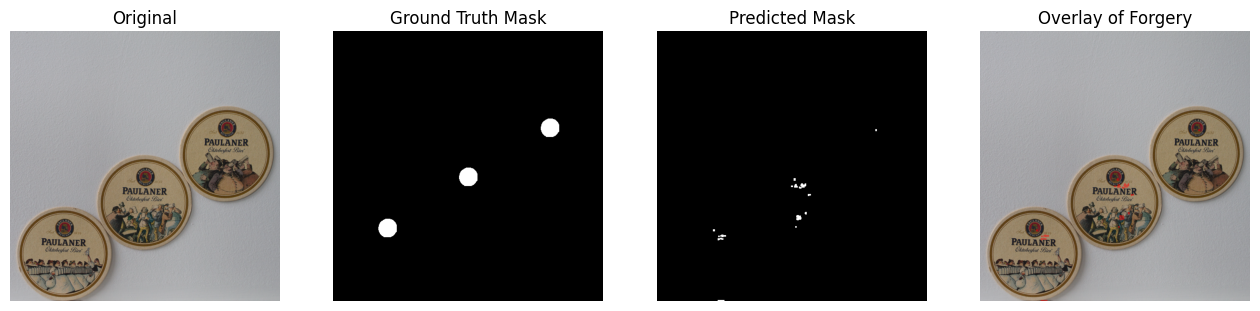

In [13]:
# Simple and Generic Binary mask


import matplotlib.pyplot as plt

def overlay_mask(image, mask, color=[255,0,0], alpha=0.5):
    """Overlay a binary mask on an image (both H×W or H×W×3)."""
    img = image.copy().astype(np.float32)
    if img.max() <= 1.0:
        img = (img*255).astype(np.uint8)
    overlay = img.copy()
    overlay[mask==1] = overlay[mask==1] * (1-alpha) + np.array(color)*(alpha)
    return overlay.astype(np.uint8)

def calculate_metrics(gt_mask, pred_mask):
    """Compute evaluation metrics."""
    gt_flat = gt_mask.flatten()
    pred_flat = pred_mask.flatten()
    precision = precision_score(gt_flat, pred_flat, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, zero_division=0)
    iou = jaccard_score(gt_flat, pred_flat, zero_division=0)
    accuracy = accuracy_score(gt_flat, pred_flat)
    return precision, recall, f1, iou, accuracy

# Example visualization for one image
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Get the directory containing the image file
image_dir = os.path.dirname(test_img)
# Construct the mask path using the image directory and filename
mask_path = os.path.join(image_dir.replace('Forged', 'B_Mask'),
                        os.path.basename(test_img).replace('_F.png', '_B.png'))

if os.path.exists(mask_path):
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 127
else:
    print(f"Error: Mask file not found at {mask_path}")
    mask_gt = None  # or handle the error in a different way

# Proceed with visualization only if mask_gt is not None
if mask_gt is not None:
    mask_pred = clean_mask.astype(bool)

    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    axes[0].imshow(img);           axes[0].set_title("Original")
    axes[1].imshow(mask_gt, cmap='gray');   axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(mask_pred, cmap='gray'); axes[2].set_title("Predicted Mask")
    axes[3].imshow(overlay_mask(img, mask_pred));
    axes[3].set_title("Overlay of Forgery")
    for ax in axes:
        ax.axis('off')
    plt.show()
else:
    print("Visualization skipped due to missing mask file.")

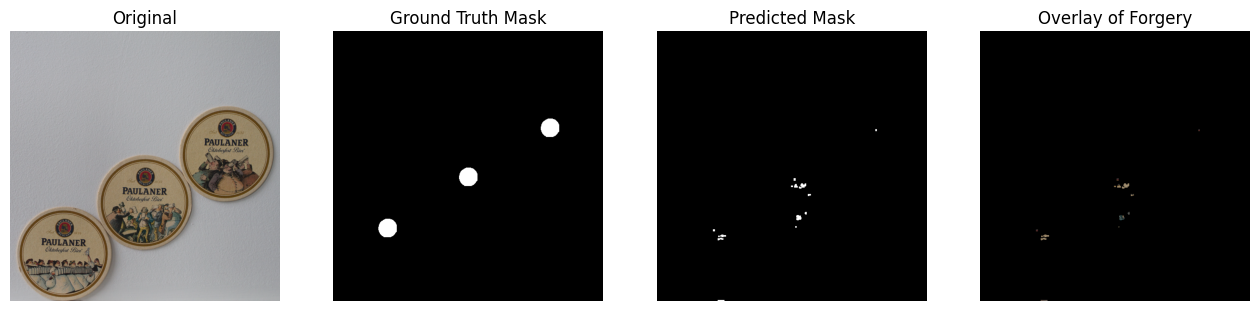

In [14]:
# Create a colored mask using the original image's pixels

import matplotlib.pyplot as plt


def overlay_mask(image, mask):
       """Overlay a binary mask on an image (both H×W or H×W×3)."""
       # Ensure image is in the range [0, 255]
       img = image.copy().astype(np.uint8)

       # Create a colored mask using the original image's pixels
       colored_mask = np.zeros_like(img)
       colored_mask[mask] = img[mask]

       return colored_mask

def calculate_metrics(gt_mask, pred_mask):
    """Compute evaluation metrics."""
    gt_flat = gt_mask.flatten()
    pred_flat = pred_mask.flatten()
    precision = precision_score(gt_flat, pred_flat, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, zero_division=0)
    iou = jaccard_score(gt_flat, pred_flat, zero_division=0)
    accuracy = accuracy_score(gt_flat, pred_flat)
    return precision, recall, f1, iou, accuracy

# Example visualization for one image
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Get the directory containing the image file
image_dir = os.path.dirname(test_img)
# Construct the mask path using the image directory and filename
mask_path = os.path.join(image_dir.replace('Forged', 'B_Mask'),
                        os.path.basename(test_img).replace('_F.png', '_B.png'))

if os.path.exists(mask_path):
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 127
else:
    print(f"Error: Mask file not found at {mask_path}")
    mask_gt = None  # or handle the error in a different way

# Proceed with visualization only if mask_gt is not None
if mask_gt is not None:
    mask_pred = clean_mask.astype(bool)

    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    axes[0].imshow(img);           axes[0].set_title("Original")
    axes[1].imshow(mask_gt, cmap='gray');   axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(mask_pred, cmap='gray'); axes[2].set_title("Predicted Mask")
    axes[3].imshow(overlay_mask(img, mask_pred));
    axes[3].set_title("Overlay of Forgery")
    for ax in axes:
        ax.axis('off')
    plt.show()
else:
    print("Visualization skipped due to missing mask file.")